Python adaptation of p. 244-247 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani, from the code by <b>R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016)</b>.

In [5]:
#%matplotlib inline
import pandas as pd
import numpy as np
import itertools   #Library with functions creating iterators for efficient looping
import time #Library for time access functions and conversions
import statsmodels.api as sm #Library for statistical models
import matplotlib.pyplot as plt

### 6.5.1 Best Subset Selection

Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year.

<b>Pre-processing the data</b>

In [6]:
hitters_data = pd.read_csv('Hitters.csv')
hitters_data.info()
hitters_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  322 non-null    object 
 1   AtBat       322 non-null    int64  
 2   Hits        322 non-null    int64  
 3   HmRun       322 non-null    int64  
 4   Runs        322 non-null    int64  
 5   RBI         322 non-null    int64  
 6   Walks       322 non-null    int64  
 7   Years       322 non-null    int64  
 8   CAtBat      322 non-null    int64  
 9   CHits       322 non-null    int64  
 10  CHmRun      322 non-null    int64  
 11  CRuns       322 non-null    int64  
 12  CRBI        322 non-null    int64  
 13  CWalks      322 non-null    int64  
 14  League      322 non-null    object 
 15  Division    322 non-null    object 
 16  PutOuts     322 non-null    int64  
 17  Assists     322 non-null    int64  
 18  Errors      322 non-null    int64  
 19  Salary      263 non-null    f

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


First of all, we note that the `Salary` variable is missing for some of the
players. The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `TRUE` value
for any elements that are missing, and a `FALSE` value for non-missing elements.
The `sum()` function can then be used to count all of the missing elements:

In [7]:
print("Number of null values:" + str(hitters_data["Salary"].isnull().sum()))

Number of null values:59


We see that `Salary` is missing for 59 players. The `dropna()` function
removes all of the rows that have missing values in any variable:

In [8]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", hitters_data.shape)

# Drop any rows the contain missing values, along with the player names
hitters_data_clean = hitters_data.dropna().drop("Unnamed: 0", axis=1)

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", hitters_data_clean.shape)

# One last check: should return 0
print("Number of null values:", hitters_data_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 20)
Number of null values: 0


Convert categorical variable into dummy/indicator variables:

In [9]:
dummies = pd.get_dummies(hitters_data_clean[['League', 'Division', 'NewLeague']])
print(dummies)

     League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
1       False      True       False        True        False         True
2        True     False       False        True         True        False
3       False      True        True       False        False         True
4       False      True        True       False        False         True
5        True     False       False        True         True        False
..        ...       ...         ...         ...          ...          ...
317     False      True        True       False        False         True
318      True     False        True       False         True        False
319      True     False       False        True         True        False
320      True     False        True       False         True        False
321      True     False       False        True         True        False

[263 rows x 6 columns]


Read the response variable ("Salary")... 

In [10]:
y = hitters_data_clean.Salary
#print(y)

...and reorganize the predictors:

In [14]:
# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = hitters_data_clean.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X. Put the dummy variables in the end
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
# print(X)

     AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat   CHits  CHmRun  \
1    315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   835.0    69.0   
2    479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   457.0    63.0   
3    496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0  1575.0   225.0   
4    321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   101.0    12.0   
5    594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0  1133.0    19.0   
..     ...    ...    ...   ...   ...    ...    ...     ...     ...     ...   
317  497.0  127.0    7.0  65.0  48.0   37.0    5.0  2703.0   806.0    32.0   
318  492.0  136.0    5.0  76.0  50.0   94.0   12.0  5511.0  1511.0    39.0   
319  475.0  126.0    3.0  61.0  43.0   52.0    6.0  1700.0   433.0     7.0   
320  573.0  144.0    9.0  85.0  60.0   78.0    8.0  3198.0   857.0    97.0   
321  631.0  170.0    9.0  77.0  44.0   31.0   11.0  4908.0  1457.0    30.0   

     CRuns   CRBI  CWalks  PutOuts  Assists  Errors  League_N  

<b>Identify the best model</b>: Here we define two functions.

(1) One function to compute the RSS for a given set of predictors (<tt>feature_set</tt>). We use function <tt>OLS</tt> (Ordinary Least Squares) from the statsmodels.

In [12]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

(2) One function to retrieve the best set of variables for each model size (i.e. fixed number of predictors k). 
Note that <tt>loc</tt> is to access a group of rows and columns by label(s) or a boolean array. For k=2 we should have:

In [15]:
k=2
tic = time.time()  #This is just to compare how fast we are...  
results = [] #Initialize a vector
for combo in itertools.combinations(X.columns, k):  #"combo" labels each combination of k predictors
    #print(combo)
    results.append(processSubset(combo))  
# Wrap everything up in a nice dataframe
models = pd.DataFrame(results)
#Entry with minimum RSS:
print(models["RSS"].argmin())
# Choose the model with the highest RSS
best_model = models.loc[models['RSS'].argmin()]  
print(best_model)
toc = time.time()
print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

So, the function should look like:

In [ ]:
def getBest(k):
    tic = time.time()  #This is just to compare how fast we are...
    results = [] #Initialize a vector
    for combo in itertools.combinations(X.columns, k):  #"combo" labels each combination of k predictors
        results.append(processSubset(combo))
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

This returns a `DataFrame` containing the best model that we generated, along with some extra information about the model. Now we want to call that function for each number of predictors $k$:

In [ ]:
# Could take quite a while to complete...
models_best = pd.DataFrame(columns=["RSS", "model"])
tic = time.time() #Initial time
# Lets make (for now...) small number of predictors:
maxnpred=5
for i in range(1,maxnpred):
     models_best.loc[i] = getBest(i)
toc = time.time() #Final time
print("Total elapsed time:", (toc-tic), "seconds.")

/home/plind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  if __name__ == '__main__':


Processed 19 models on 1 predictors in 0.07713627815246582 seconds.
Processed 171 models on 2 predictors in 0.34920477867126465 seconds.
Processed 969 models on 3 predictors in 1.664940357208252 seconds.
Processed 3876 models on 4 predictors in 6.850605010986328 seconds.
Total elapsed time: 8.951462268829346 seconds.


Now we have one big `DataFrame` that contains the best models we've generated along with their RSS:

In [ ]:
models_best

,RSS,model
1,4.321393e+07,<statsmodels.regression.linear_model.Regressio...
2,3.073305e+07,<statsmodels.regression.linear_model.Regressio...
3,2.941071e+07,<statsmodels.regression.linear_model.Regressio...
4,2.797678e+07,<statsmodels.regression.linear_model.Regressio...


The <tt>RSS</tt> decreases with the number of predictors. If we want to access the details of each model, no problem! We can get a full rundown of a single model using the `summary()` function:

In [ ]:
print(models_best.loc[2, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Wed, 23 Sep 2020   Prob (F-statistic):                    5.80e-82
Time:                        05:16:34   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This output indicates that the best two-variable model
contains only `Hits` and `CRBI`. To save time, we only generated results
up to the best 7-variable model. You can use the functions we defined above to explore as many variables as are desired.

In [ ]:
# Show the best 19-variable model (there's actually only one)
print(getBest(19)["model"].summary())

Processed 1 models on 19 predictors in 0.02586650848388672 seconds.
                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.810
Model:                            OLS   Adj. R-squared (uncentered):              0.795
Method:                 Least Squares   F-statistic:                              54.64
Date:                Wed, 23 Sep 2020   Prob (F-statistic):                    1.31e-76
Time:                        05:17:50   Log-Likelihood:                         -1877.9
No. Observations:                 263   AIC:                                      3794.
Df Residuals:                     244   BIC:                                      3862.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>

/home/plind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  if __name__ == '__main__':


Rather than letting the results of our call to the `summary()` function print to the screen, we can access just the parts we need using the model's attributes. For $R^2$, adjusted $R^2$, AIC, and BIC values:

In [ ]:
print(models_best.loc[2, "model"].rsquared)
print(models_best.loc[2, "model"].bic)  
print(models_best.loc[2, "model"].aic)  
print(models_best.loc[2, "model"].rsquared_adj)

0.7614950002332872
3826.372838539718
3819.2285304753623
0.759667375714002


You can also write your own function, e.g.:

In [ ]:
#def mystatistics(N,p,rss):
#     adjr2 = ...
#     aic = ...
#     bic = ...
#     return {"adjr2":adjr2, "aic":aic, "bic":bic}

Excellent! In addition to the verbose output we get when we print the summary to the screen, fitting the `OLM` also produced many other useful statistics such as adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [ ]:
# Gets the second element from each row ('model') and pulls out its rsquared attribute
print(models_best.apply(lambda row: row[1].rsquared, axis=1))
#For aic e.g.
print(models_best.apply(lambda row: row[1].aic, axis=1))

1    0.664637
2    0.761495
3    0.771757
4    0.782885
dtype: float64
1    3906.865252
2    3819.228530
3    3809.661852
4    3798.516052
dtype: float64


As expected, the $R^2$ statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted $R^2$, AIC, and BIC for all of the models at once will
help us decide which model to select. Note the `type="l"` option tells `R` to
connect the plotted points with lines:

/home/plind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
/home/plind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
/home/plind/.local/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


Text(0,0.5,'BIC')

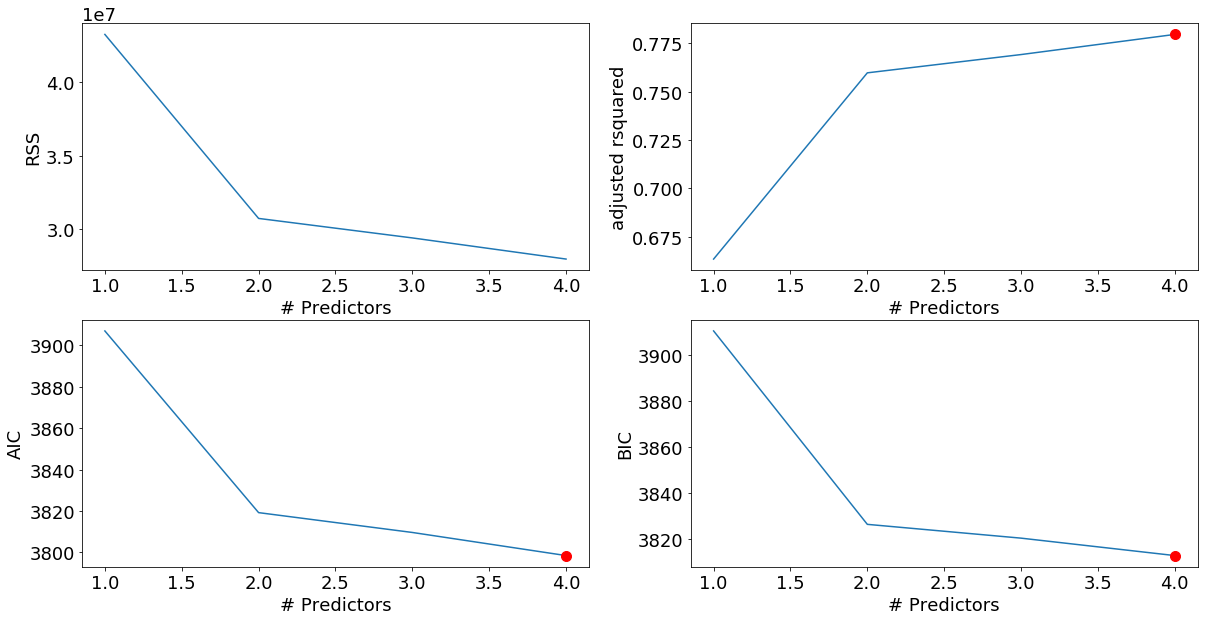

In [ ]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plt.plot(models_best["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

Recall that in the second step of our selection process, we narrowed the field down to just one model on any $k<=p$ predictors. We see that according to BIC, the best performer is the model with 6 variables. According to AIC and adjusted $R^2$ something a bit more complex might be better. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.